In [1]:
from datetime import datetime
import requests
import pandas as pd
from bs4 import BeautifulSoup
import csv
import re
import matplotlib.pyplot as plt
from unidecode import unidecode

In [2]:
df = pd.read_csv('gru.csv')

In [3]:
df.describe()

,name,address,car,unit
count,909,909,909,908
unique,907,81,559,76
top,Chekashkin Dmitry Nikolaevich 23.06.1981,-,-,-
freq,2,624,350,826


## Ages

How old are the agents? 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   name         909 non-null    object  
 1   age          713 non-null    float64 
 2   age_bracket  713 non-null    category
dtypes: category(1), float64(1), object(1)
memory usage: 15.6+ KB
We have a dob for about 7/9 values: None 

,


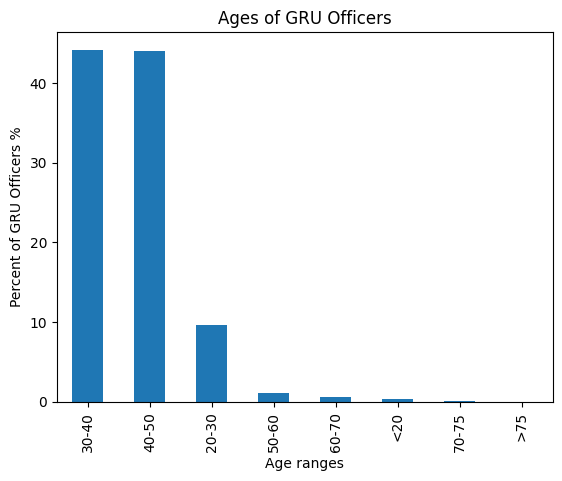

In [4]:
def calc_age(df: pd.DataFrame) -> pd.DataFrame:
    df['dob'] = df['name'].str.extract(r'(\d{1,2}\.\d{1,2}\.\d{4})')
    df['dob'] = pd.to_datetime(df['dob'], format='%d.%m.%Y', errors='coerce')
    df['age'] = df['dob'].apply(lambda x: pd.Timestamp('now').year - x.year if pd.notnull(x) else None)
    return df

def bin_ages(age:pd.Series) -> pd.Series:
    bin_edges = [0, 20, 30, 40, 50, 60, 70, 75, float('inf')]
    bin_labels = ["<20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-75", ">75"]
    age_bins = pd.cut(age, bins=bin_edges, labels=bin_labels, right=False)
    return age_bins

df = calc_age(df.copy())
df['age_bracket'] = bin_ages(df['age'].copy())

print("We have a dob for about 7/9 values: %s \n\n," % df[['name','age', 'age_bracket']].info())

ax = df['age_bracket'].value_counts(dropna=True, normalize=True).apply(lambda x: x * 100).plot(kind='bar', title='Ages of GRU Officers')
ax.set_ylabel('Percent of GRU Officers %')
ax.set_xlabel('Age ranges')

plt.savefig('./ages.png', bbox_inches='tight')

In [5]:
df[df['age_bracket'] == '<20']

,name,address,car,unit,dob,age,age_bracket
208,Davydovskaya Sofya Andreevna 01.05.2009,-,-,-,2009-05-01,15.0,<20
708,Soldatov Ivan Alekseevich 18.03.2009,-,-,-,2009-03-18,15.0,<20


The average age in our sample is 38: 

## Most common names

In [6]:
def parse_names(name):

    name = name.str.split(' ', expand=True)
    return name.iloc[:, :3]

names = pd.DataFrame()
names[['first_name', 'middle_name', 'last_name']] = parse_names(df['name'])

print("Most common first name:\n %s \n\nMost common surname \n\n%s," %(
    names['first_name'].value_counts().nlargest(4).reset_index(), 
    names['last_name'].value_counts().nlargest(4).reset_index(), 

     )
)

Most common first name:
   first_name  count
0  Kuznetsov      7
1    Smirnov      6
2  Marchenko      6
3   Alekseev      6 

Most common surname 

       last_name  count
0  Alexandrovich     83
1  Vladimirovich     76
2     Sergeevich     60
3      Yuryevich     52,


## Most common car

In [7]:
def parse_car(df: pd.DataFrame) -> pd.DataFrame:
    # Values: car, year, number, VIN

    #filter_df_1 = df['car'].str.split('.', expand=True)
    
    df['car'] = df['car'].str.replace('.', '')
    
    print(df['car'][3])
    pattern = (
        r"(?P<car_model>[A-Za-z\s]+)?"          # Car model (letters and spaces)
        r"\s*(?P<car_year>\d{4})?"              # 4-digit year
        r"\s*(?:number\s*)?(?P<car_plate>[A-Z0-9]+)?"  # Optional 'number' label and plate
        r"\s*(?:VIN\s*[:\-]?\s*)?"              # Optional 'VIN' label with possible spacing and punctuation
        r"(?P<car_vin>[A-Z0-9]{17})?"           # 17-character VIN
    )
    filter_df = df['car'].str.extract(pattern)
    return filter_df
      

df['car'] = df['car'].str.strip()
df['car'] = df['car'].apply(unidecode)
parsed_car = parse_car(df.copy())
df = df.merge(parsed_car, left_index=True, right_index=True)

Hyundai TUCSON 2017 number O350AN799


In [8]:
def car_brand(model: pd.Series) -> pd.Series:
    brand = model[model.isna() == False]
    brand = brand.str.split(' ', expand=True)[0].str.upper().str.strip()
    remove_digits = lambda x: ''.join([char for char in x[0:] if not char.isdigit()])  # Skip first character
    remove_hyphen = lambda x: ''.join([i.replace('-', '') for i in x])
    remove_bmw = lambda x: re.sub(r'(bmw).*', r'\1', x, flags=re.IGNORECASE)
    ['BMVH', 'NISSANTI', 'MITSUVISNI', 'MITSUBICISI']
    brand = brand.apply(remove_digits).apply(remove_hyphen).apply(remove_bmw)
    return brand.reindex(model.index)

df['brand'] = car_brand(df['car_model'])

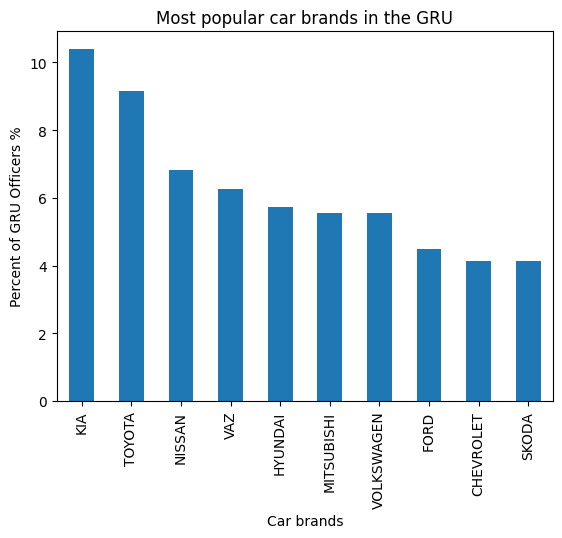

In [9]:
#df.groupby('car_year').count().plot(kind='bar')
ax = df['brand'].value_counts(dropna=True, normalize=True).nlargest(10).apply(lambda x: x*100).plot(kind='bar')
ax.set_title('Most popular car brands in the GRU')
ax.set_ylabel("Percent of GRU Officers %")
ax.set_xlabel("Car brands")
plt.savefig('./most_popular_brands.png', bbox_inches='tight')

In [10]:
df['car'] = df['car_model'].copy().map(lambda x: None if isinstance(x, float) else x.upper().strip()) + ' ' + df['car_year'].copy()
car_model = df['car'].value_counts(dropna=True)
pop_car = df['brand'].value_counts(dropna=True).nlargest(3).reset_index()['brand']
pop_car = df[df['brand'].isin(pop_car) == True]
pop_car = pop_car.groupby(['brand', 'car', 'car_model', 'car_year'])['car'].count().reset_index(name='count')
pop_car.query('count > 1')[['car', 'car_year']]
#df['car'].value_counts(dropna=True, normalize=True).nlargest(10).apply(lambda x: x*100).plot(kind='bar')


,car,car_year
12,KIA RIO 2016,2016
13,KIA RIO 2017,2017
27,NISSAN MAXIM 1996,1996
31,NISSAN QASHQAI 2011,2011
43,TOYOTA AVENSIS 2008,2008
45,TOYOTA CAMRY 2002,2002
49,TOYOTA CAMRY 2011,2011
52,TOYOTA CAMRY 2016,2016
57,TOYOTA COROLLA 2008,2008
61,TOYOTA HIGHLANDER 2014,2014


In [11]:
df['car_year'].value_counts(dropna=True, normalize=True).nlargest().apply(lambda x: x*100)

car_year
2008    12.576687
2011    12.269939
2017     7.975460
2007     7.668712
2016     6.441718
Name: proportion, dtype: float64

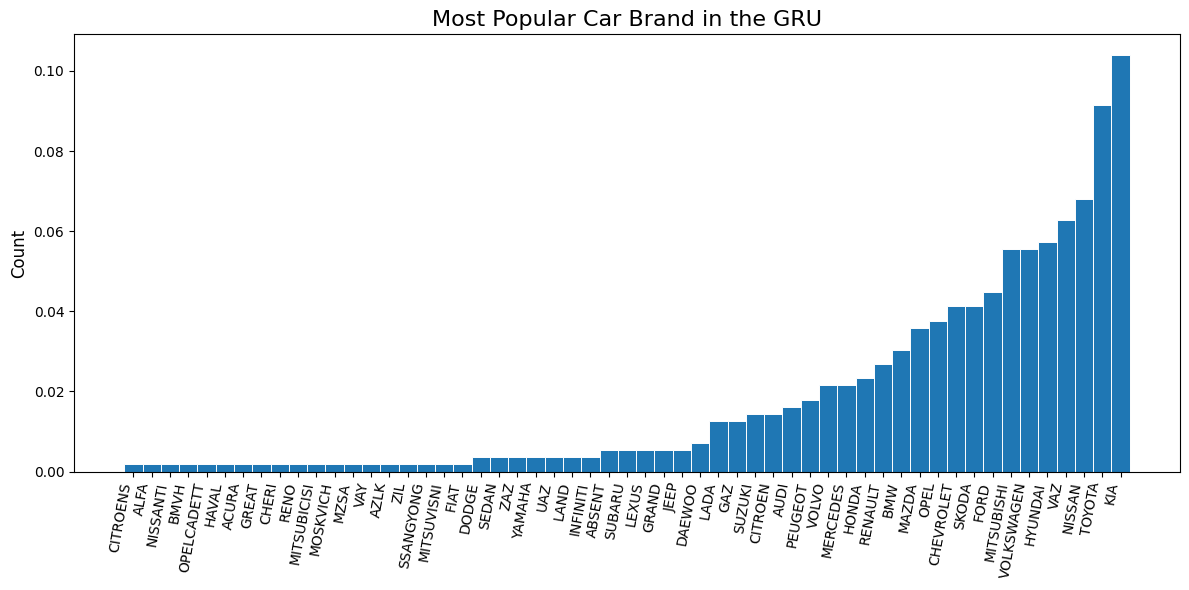

In [12]:
def plot_bar_brand(df)-> None:
    x = df['brand'].copy().value_counts(normalize=True).reset_index().sort_values(by='proportion', ascending=True)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x['brand'], x['proportion'], width=1, edgecolor="white", linewidth=0.7)
    # Set labels and title
    ax.set_title('Most Popular Car Brand in the GRU', fontsize=16)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticks(range(len(x['brand'])))
    ax.set_xticklabels(x['brand'], rotation=80, ha='right')  # Rotate labels for readability
    plt.tight_layout()
    plt.show()

plot_bar_brand(df)

## Address

In [46]:
import re
df['name'] = df['name'].apply(lambda x: re.sub(r"\b\d{2}\.\d{2}\.\d{4}\b", '', x))
df[['name', 'unit']].query('unit.isna() ==  False & unit != "-"').set_index('name').sort_values(by='unit', ascending=True).to_clipboard()


In [14]:

def write_csv(df):
    with pd.ExcelWriter('gru.xlsx') as writer:
        df.to_excel(writer, sheet_name='main')
        car_model.to_excel(writer, sheet_name='car_model_count')
        
write_csv(df)
